# Exploratory Data Analysis (EDA) - Data Science

- Steps:
    - Understand the dataset - assess the quality of the dataset
    - Distribute of the dataset - How does the data look like?
    - Correlactions - Find patterns in the dataset

In [470]:
###############################################################
################### DATA CLEANING #############################
###############################################################

In [471]:
#!pip install pandas-profiling

In [472]:
import pandas                   as pd
import sys
import itertools
from collections               import Counter
import numpy                   as np
import gc # Garbage Collector interface
import feather
import time
from datetime                  import datetime
import matplotlib.pyplot       as plt
import seaborn                 as sns
from sklearn.feature_selection import mutual_info_classif
import plotly.express          as ex
from matplotlib                import pyplot

from sklearn.preprocessing     import OneHotEncoder
from sklearn.preprocessing     import LabelEncoder

from pandas_profiling          import ProfileReport

# Normality tests
from scipy.stats import normaltest

%matplotlib inline

pd.set_option('max_columns', 120)
pd.set_option('max_colwidth', 5000)

plt.rcParams['figure.figsize'] = (20, 20)

##### >>> https://towardsdatascience.com/a-straightforward-guide-to-cleaning-and-preparing-data-in-python-8c82f209ae33
# source dataset: https://www.dataquest.io/blog/machine-learning-preparing-data/

# data cleaning - sources
# https://medium.com/sciforce/data-cleaning-and-preprocessing-for-beginners-25748ee00743
# https://medium.com/bitgrit-data-science-publication/data-cleaning-with-python-f6bc3da64e45
# https://towardsdatascience.com/the-ultimate-guide-to-data-cleaning-3969843991d4
# https://towardsdatascience.com/data-cleaning-and-feature-engineering-the-underestimated-parts-of-machine-learning-10681dae4cf7

# Pandas has a high consume of memory RAM usage
# release memory RAM
def release_memory(df):   
    del df
    gc.collect() 
    df = pd.DataFrame() # point to NULL
    print('memory RAM released.')

# Get start time 
start_time = time.time()

# datetime object containing current date and time
now = datetime.now()

# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print(">>> date: ", dt_string)

>>> date:  15/08/2021 19:18:04


## Quick Dataset Overview

In [473]:
# dataframe - df
# read csv file, the columns are separated (sep) by ','
df = pd.read_csv('../data/lending_club_loans_2007_2011.csv', skiprows=1, low_memory=False)

half_count = len(df) / 2
df = df.dropna(thresh=half_count,axis=1) # Drop any column with more than 50% missing values
df = df.drop(['url','desc', 'initial_list_status','pymnt_plan'],axis=1) # These columns are not useful for our purposes

In [474]:
# After analyzing the columns and considering the model we’re 
# trying to build, we can conclude that the following features 
# can be removed:

drop_list = ['id','member_id','funded_amnt','funded_amnt_inv',
             'int_rate','sub_grade','emp_title','issue_d', 'zip_code',
             'out_prncp','out_prncp_inv', 'total_pymnt','total_pymnt_inv',
             'total_rec_prncp','total_rec_int',
             'total_rec_late_fee','recoveries',
             'collection_recovery_fee', 'last_pymnt_d',
             'last_pymnt_amnt', 'policy_code'
            ]
            
df = df.drop(drop_list,axis=1)

In [475]:
print(f'Number of rows.....................: {df.shape[0]}')
print(f'Number of columns..................: {df.shape[1]}')

Number of rows.....................: 42538
Number of columns..................: 33


In [476]:
# % of rows missing in each column
list_columns_nan = list()

print('% of rows missing in each column')
for column in df.columns:
    percentage = df[column].isnull().mean()
    if(percentage != 0):
        print(f'{column}: {round(percentage*100, 2)}%')
        list_columns_nan.append(column)

% of rows missing in each column
loan_amnt: 0.01%
term: 0.01%
installment: 0.01%
grade: 0.01%
emp_length: 2.62%
home_ownership: 0.01%
annual_inc: 0.02%
verification_status: 0.01%
loan_status: 0.01%
purpose: 0.01%
title: 0.04%
addr_state: 0.01%
dti: 0.01%
delinq_2yrs: 0.08%
earliest_cr_line: 0.08%
fico_range_low: 0.01%
fico_range_high: 0.01%
inq_last_6mths: 0.08%
open_acc: 0.08%
pub_rec: 0.08%
revol_bal: 0.01%
revol_util: 0.22%
total_acc: 0.08%
last_credit_pull_d: 0.02%
last_fico_range_high: 0.01%
last_fico_range_low: 0.01%
collections_12_mths_ex_med: 0.35%
application_type: 0.01%
acc_now_delinq: 0.08%
chargeoff_within_12_mths: 0.35%
delinq_amnt: 0.08%
pub_rec_bankruptcies: 3.22%
tax_liens: 0.25%


## Identify Missing Data

In [477]:
# count NaN found in the dataset
df.isna().sum()

loan_amnt                        3
term                             3
installment                      3
grade                            3
emp_length                    1115
home_ownership                   3
annual_inc                       7
verification_status              3
loan_status                      3
purpose                          3
title                           16
addr_state                       3
dti                              3
delinq_2yrs                     32
earliest_cr_line                32
fico_range_low                   3
fico_range_high                  3
inq_last_6mths                  32
open_acc                        32
pub_rec                         32
revol_bal                        3
revol_util                      93
total_acc                       32
last_credit_pull_d               7
last_fico_range_high             3
last_fico_range_low              3
collections_12_mths_ex_med     148
application_type                 3
acc_now_delinq      

## Missing value per feature - heatmap

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

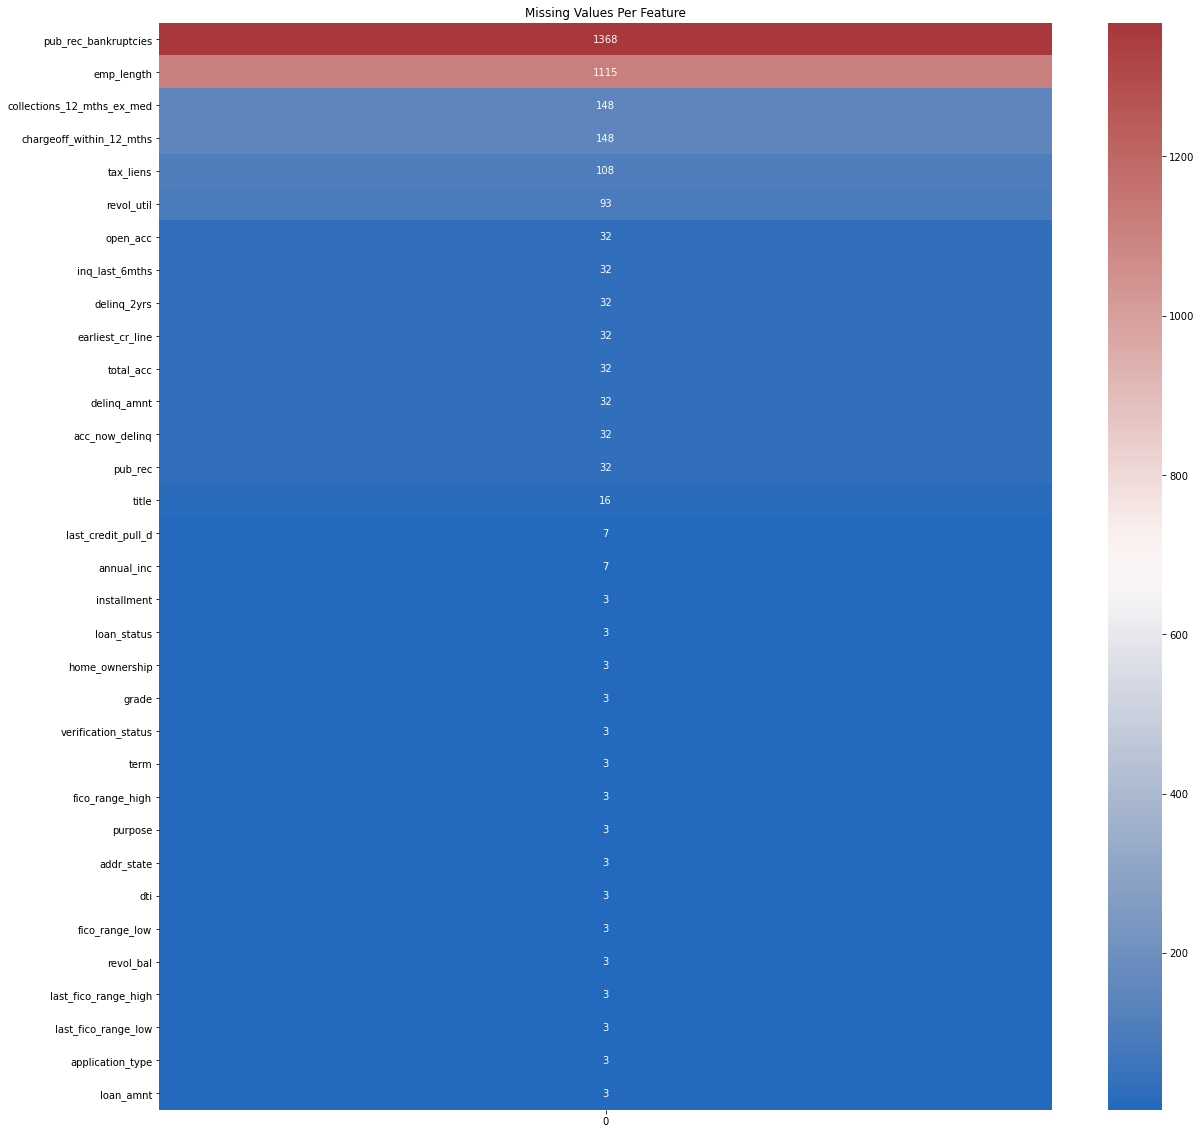

In [478]:
# heatmap - give a big picture of the missing values on the dataset.
plt.title('Missing Values Per Feature')
nans = df.isna().sum().sort_values(ascending=False).to_frame() # get NaN
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag') # seaborn

plt.savefig(f'figures/missing_values_per_feature.png')

In [479]:
#df = df.dropna() # drop rows with NaN's
df.shape

(42538, 33)

In [480]:
# remove rows with missing data
#df = df.dropna()

# drop a column
# df.drop('column_name', axis=1)

#half_count = len(df) / 2  # 50% of the dataset
#df = df.dropna(thresh=half_count,axis=1) # Drop any column with more than 50% missing values

In [481]:
df[list_columns_nan].head()

,loan_amnt,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,title,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,5000.0,36 months,162.87,B,10+ years,RENT,24000.0,Verified,Fully Paid,credit_card,Computer,AZ,27.65,0.0,Jan-1985,735.0,739.0,1.0,3.0,0.0,13648.0,83.7%,9.0,Sep-2016,744.0,740.0,0.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,2500.0,60 months,59.83,C,< 1 year,RENT,30000.0,Source Verified,Charged Off,car,bike,GA,1.00,0.0,Apr-1999,740.0,744.0,5.0,3.0,0.0,1687.0,9.4%,4.0,Sep-2016,499.0,0.0,0.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,2400.0,36 months,84.33,C,10+ years,RENT,12252.0,Not Verified,Fully Paid,small_business,real estate business,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,2.0,0.0,2956.0,98.5%,10.0,Sep-2016,719.0,715.0,0.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3,10000.0,36 months,339.31,C,10+ years,RENT,49200.0,Source Verified,Fully Paid,other,personel,CA,20.00,0.0,Feb-1996,690.0,694.0,1.0,10.0,0.0,5598.0,21%,37.0,Apr-2016,604.0,600.0,0.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
4,3000.0,60 months,67.79,B,1 year,RENT,80000.0,Source Verified,Current,other,Personal,OR,17.94,0.0,Jan-1996,695.0,699.0,0.0,15.0,0.0,27783.0,53.9%,38.0,Sep-2016,694.0,690.0,0.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0


In [482]:
# remove a special character on dataframe
df['revol_util'] = df['revol_util'].str.replace('%', '')
#df['int_rate'] = df['int_rate'].str.replace('%', '')

# Convert object to float
df['revol_util'] = df['revol_util'].astype(float)

# convert obejcto category
list_cat = ['last_credit_pull_d']

for ilist in list_cat:
    df[f'{ilist}'] = df[f'{ilist}'].astype('category')

In [483]:
df[list_columns_nan].dtypes

loan_amnt                      float64
term                            object
installment                    float64
grade                           object
emp_length                      object
home_ownership                  object
annual_inc                     float64
verification_status             object
loan_status                     object
purpose                         object
title                           object
addr_state                      object
dti                            float64
delinq_2yrs                    float64
earliest_cr_line                object
fico_range_low                 float64
fico_range_high                float64
inq_last_6mths                 float64
open_acc                       float64
pub_rec                        float64
revol_bal                      float64
revol_util                     float64
total_acc                      float64
last_credit_pull_d            category
last_fico_range_high           float64
last_fico_range_low      

In [484]:
# the mode replaces categorical data.
#mode = ''.join(df['emp_length'].mode())
#df['emp_length'].fillna(mode, inplace=True)

# datetime
#list_datetime = ['last_pymnt_d', 'last_credit_pull_d']

#for ilist in list_datetime:
#    mode = ''.join(df[f'{ilist}'].mode())
#    df[f'{ilist}'].fillna(mode, inplace=True)


# list columns float
#list_impute_mean = ['revol_util',
#                    'collections_12_mths_ex_med',
#                    'chargeoff_within_12_mths',
#                    'pub_rec_bankruptcies',
#                    'tax_liens'
#                   ]

# impute mean to missing values
#df = df.fillna(df[list_impute_mean].mean())

## Target 

In [485]:
df_target = df['loan_status'].value_counts(normalize=True).map('{:.2%}'.format)
df_target = dict(df_target)
df_target

{'Fully Paid': '78.96%',
 'Charged Off': '13.29%',
 'Does not meet the credit policy. Status:Fully Paid': '4.67%',
 'Does not meet the credit policy. Status:Charged Off': '1.79%',
 'Current': '1.21%',
 'In Grace Period': '0.04%',
 'Late (31-120 days)': '0.03%',
 'Late (16-30 days)': '0.01%',
 'Default': '0.00%'}

In [486]:
df.shape

(42538, 33)

In [487]:
list_drop_target = ['Late (31-120 days)',
                    'Current',
                    'Late (16-30 days)',
                    'In Grace Period',
                    'Default',
                    'Does not meet the credit policy. Status:Fully Paid',
                    'Does not meet the credit policy. Status:Charged Off'
                   ]

for drop_target in list_drop_target:
    index_drop_target = df[ (df['loan_status'] == f'{drop_target}')].index
    df.drop(index_drop_target, inplace = True)

df.shape

(39242, 33)

In [488]:
df['loan_status'].value_counts(normalize=True).map('{:.2%}'.format)

Fully Paid     85.59%
Charged Off    14.41%
Name: loan_status, dtype: object

In [489]:
df_tar = pd.DataFrame([df_target])
df_tar

list_col = list(df_tar.columns)

for col in list_col:
    df_tar[f'{col}'] = df_tar[f'{col}'].str.replace('%', '')

df_tar[df_tar.select_dtypes(['object']).columns] = df_tar.select_dtypes(['object']).apply(lambda x: x.astype('float64'))
df_tar.dtypes

Fully Paid                                             float64
Charged Off                                            float64
Does not meet the credit policy. Status:Fully Paid     float64
Does not meet the credit policy. Status:Charged Off    float64
Current                                                float64
In Grace Period                                        float64
Late (31-120 days)                                     float64
Late (16-30 days)                                      float64
Default                                                float64
dtype: object

## Visualizing the Target Column Outcomes

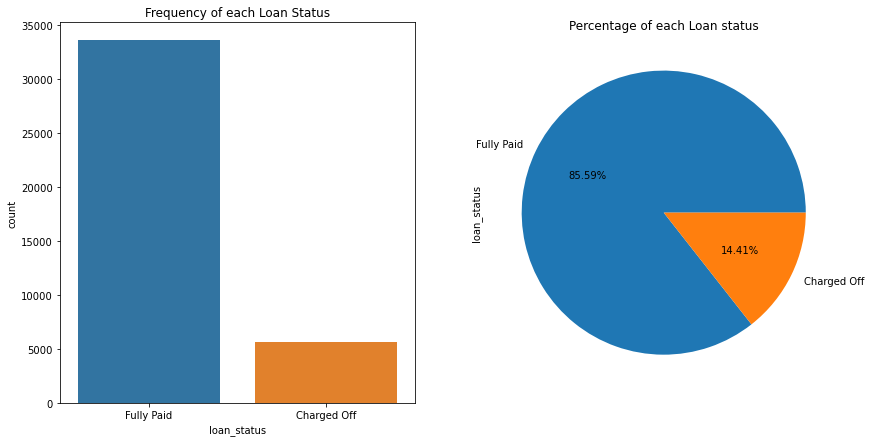

In [490]:
fig, axs = plt.subplots(1,2,figsize=(14,7))

sns.countplot(x='loan_status',data=df,ax=axs[0])
axs[0].set_title("Frequency of each Loan Status")
df['loan_status'].value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')
axs[1].set_title("Percentage of each Loan status")
plt.savefig('pictures/target_stat.png')
plt.show()


In [491]:
#df[list_columns_nan].dtypes

In [492]:
print(df['fico_range_low'].unique())
print(df['fico_range_high'].unique())

[735. 740. 690. 730. 660. 675. 725. 695. 710. 705. 720. 665. 670. 760.
 685. 755. 680. 700. 790. 750. 715. 765. 745. 770. 780. 775. 795. 810.
 800. 815. 785. 805. 825. 820. 630. 625.  nan]
[739. 744. 694. 734. 664. 679. 729. 699. 714. 709. 724. 669. 674. 764.
 689. 759. 684. 704. 794. 754. 719. 769. 749. 774. 784. 779. 799. 814.
 804. 819. 789. 809. 829. 824. 634. 629.  nan]


## Convert Feature (type: object) to Category

In [493]:
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))

In [494]:
df.dtypes

loan_amnt                      float64
term                          category
installment                    float64
grade                         category
emp_length                    category
home_ownership                category
annual_inc                     float64
verification_status           category
loan_status                   category
purpose                       category
title                         category
addr_state                    category
dti                            float64
delinq_2yrs                    float64
earliest_cr_line              category
fico_range_low                 float64
fico_range_high                float64
inq_last_6mths                 float64
open_acc                       float64
pub_rec                        float64
revol_bal                      float64
revol_util                     float64
total_acc                      float64
last_credit_pull_d            category
last_fico_range_high           float64
last_fico_range_low      

In [495]:
# instantiate labelencoder object
le = LabelEncoder()
categorical_cols = list(df.select_dtypes(['category']))

# apply le on categorical feature columns
df[categorical_cols] = df[categorical_cols].apply(lambda col: le.fit_transform(col))

In [496]:
categorical_cols

['term',
 'grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'loan_status',
 'purpose',
 'title',
 'addr_state',
 'earliest_cr_line',
 'last_credit_pull_d',
 'application_type']

39242
39239


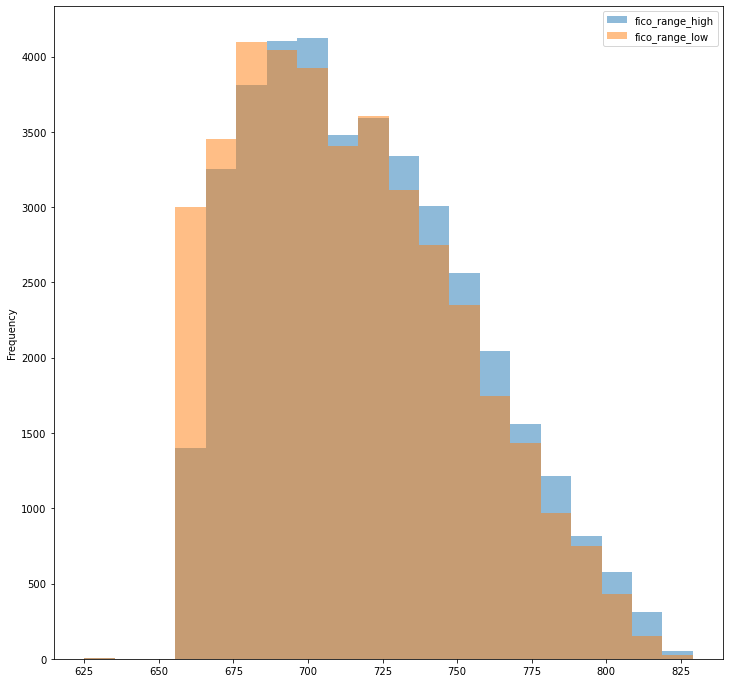

In [497]:
fico_columns = ['fico_range_high','fico_range_low']

print(df.shape[0])

df.dropna(subset=fico_columns,inplace=True)
print(df.shape[0])

plt.rcParams['figure.figsize'] = (12, 12)

df[fico_columns].plot.hist(alpha=0.5,bins=20)
plt.savefig('pictures/fico_range_stat.png')

In [498]:
df['fico_average'] = (df['fico_range_high'] + df['fico_range_low']) / 2

cols = ['fico_range_low','fico_range_high','fico_average']

In [499]:
drop_cols = ['fico_range_low','fico_range_high','last_fico_range_low', 'last_fico_range_high']
df = df.drop(drop_cols, axis=1)
df.shape

(39239, 30)

In [500]:
df

,loan_amnt,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,title,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,collections_12_mths_ex_med,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,fico_average
0,5000.0,0,162.87,1,1,4,24000.0,2,1,1,2937,3,27.65,0.0,191,1.0,3.0,0.0,13648.0,83.7,9.0,109,0.0,0,0.0,0.0,0.0,0.0,0.0,737.0
1,2500.0,1,59.83,2,10,4,30000.0,1,0,0,16119,10,1.00,0.0,33,5.0,3.0,0.0,1687.0,9.4,4.0,109,0.0,0,0.0,0.0,0.0,0.0,0.0,742.0
2,2400.0,0,84.33,2,1,4,12252.0,0,1,11,18786,14,8.72,0.0,425,2.0,2.0,0.0,2956.0,98.5,10.0,109,0.0,0,0.0,0.0,0.0,0.0,0.0,737.0
3,10000.0,0,339.31,2,1,4,49200.0,1,1,9,18679,4,20.00,0.0,160,1.0,10.0,0.0,5598.0,21.0,37.0,7,0.0,0,0.0,0.0,0.0,0.0,0.0,692.0
5,5000.0,0,156.46,0,3,4,36000.0,1,1,13,10599,3,11.20,0.0,428,3.0,9.0,0.0,7963.0,28.3,12.0,44,0.0,0,0.0,0.0,0.0,0.0,0.0,732.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39781,2500.0,0,78.42,0,4,0,110000.0,0,1,4,7602,5,11.33,0.0,414,0.0,13.0,0.0,7274.0,13.1,40.0,58,NaN,0,0.0,NaN,0.0,NaN,NaN,762.0
39782,8500.0,0,275.38,2,3,4,18000.0,0,1,1,13533,27,6.40,1.0,107,1.0,6.0,0.0,8847.0,26.9,9.0,48,NaN,0,0.0,NaN,0.0,NaN,NaN,692.0
39783,5000.0,0,156.84,0,10,0,100000.0,0,1,2,9612,19,2.30,0.0,468,0.0,11.0,0.0,9698.0,19.4,20.0,55,NaN,0,0.0,NaN,0.0,NaN,NaN,742.0
39784,5000.0,0,155.38,0,10,0,200000.0,0,1,9,8260,20,3.72,0.0,412,0.0,17.0,0.0,85607.0,0.7,26.0,55,NaN,0,0.0,NaN,0.0,NaN,NaN,812.0


/home/andsilva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


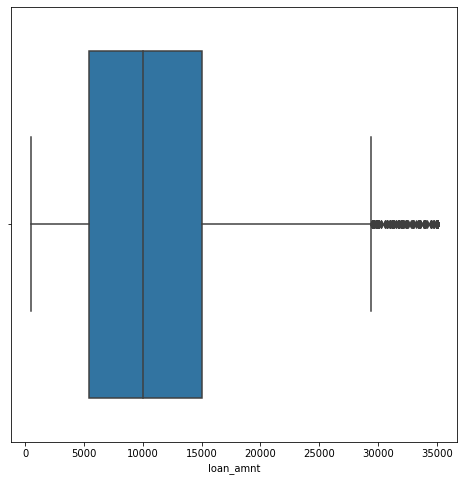

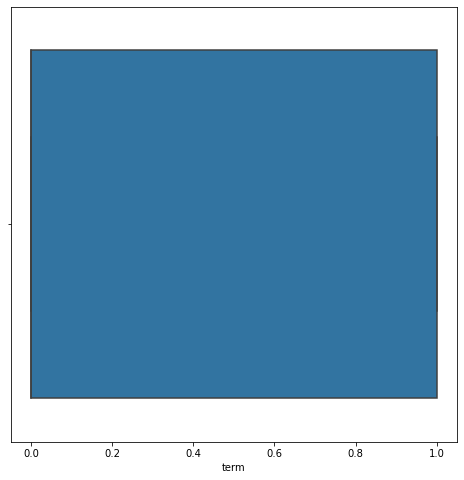

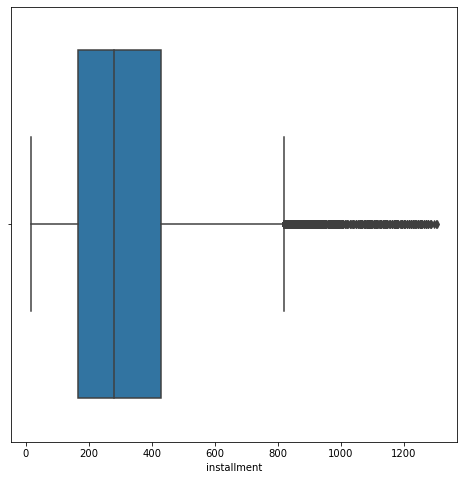

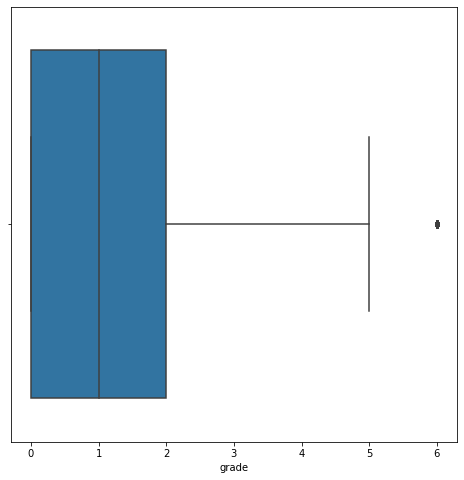

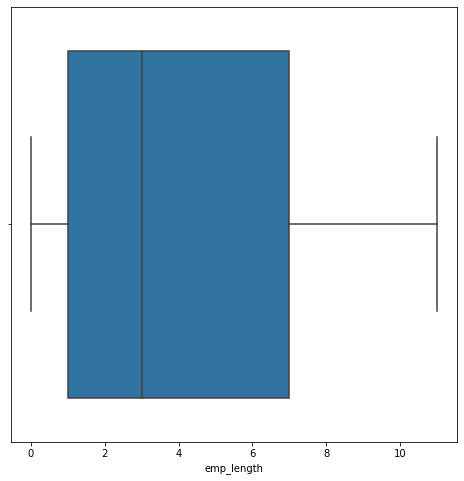

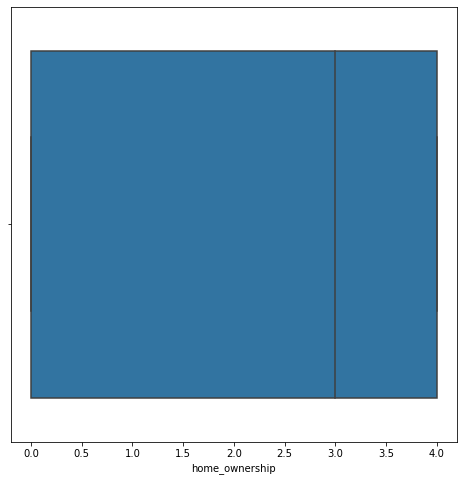

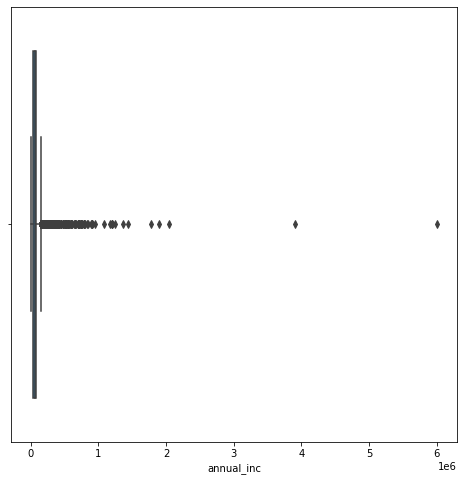

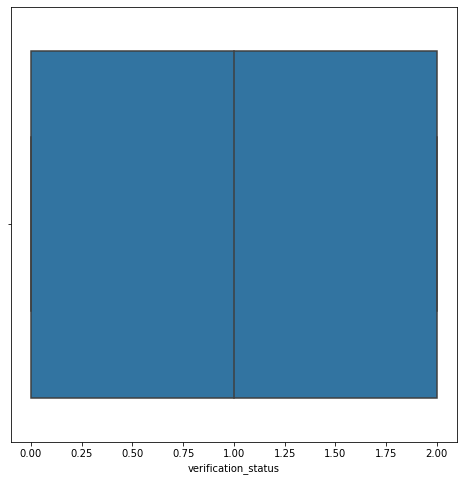

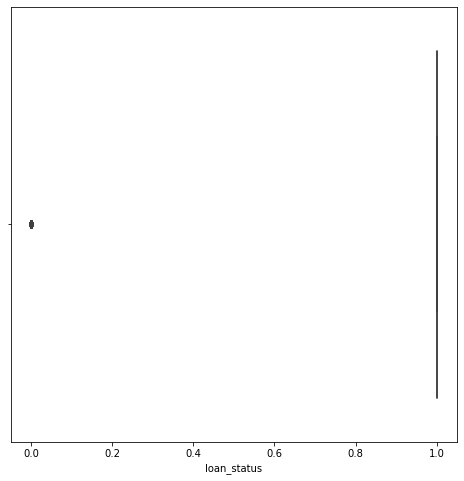

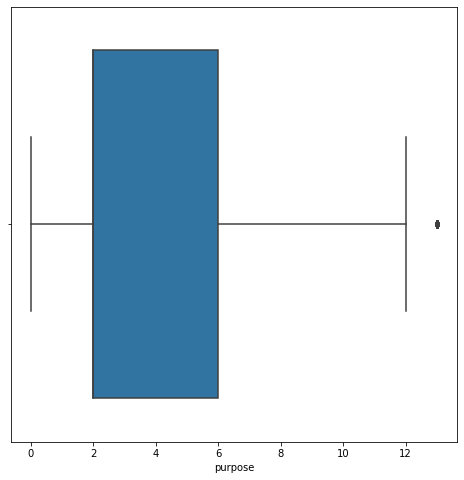

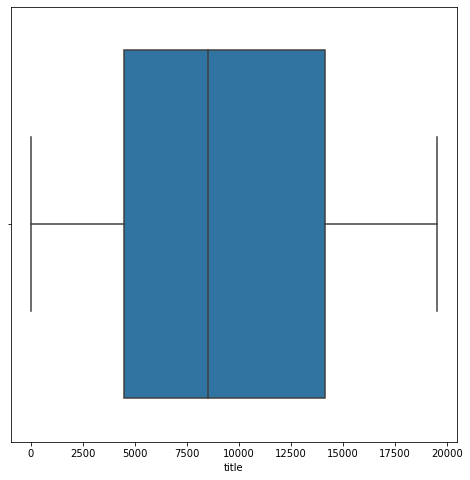

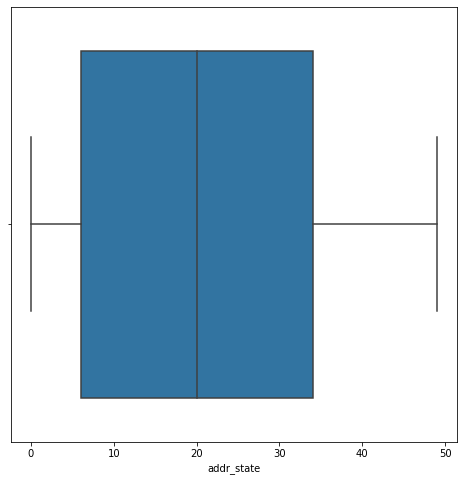

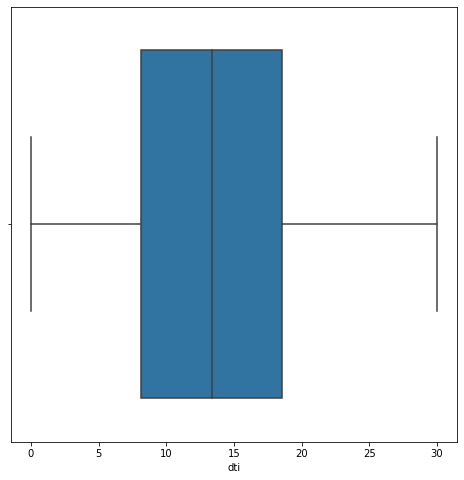

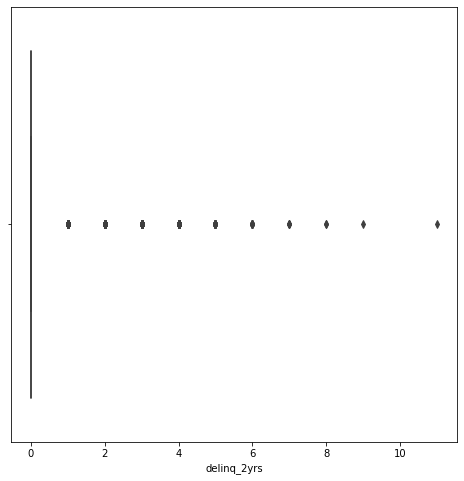

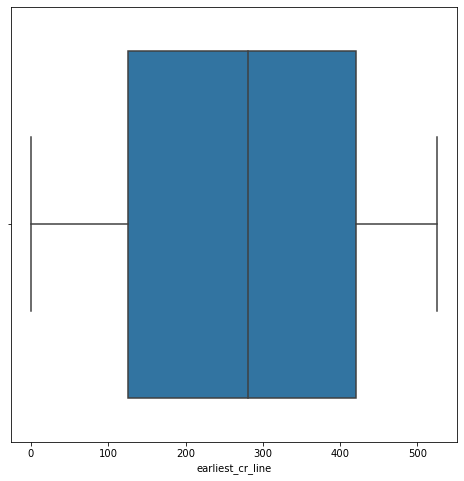

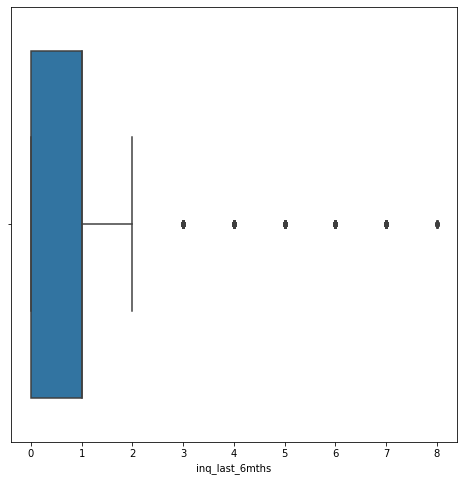

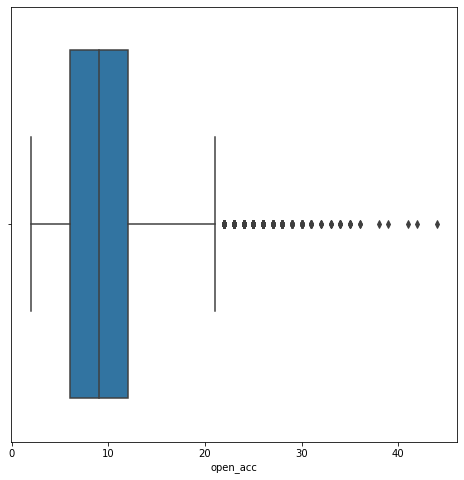

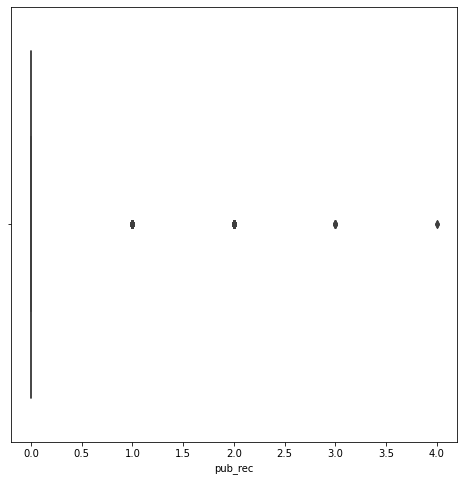

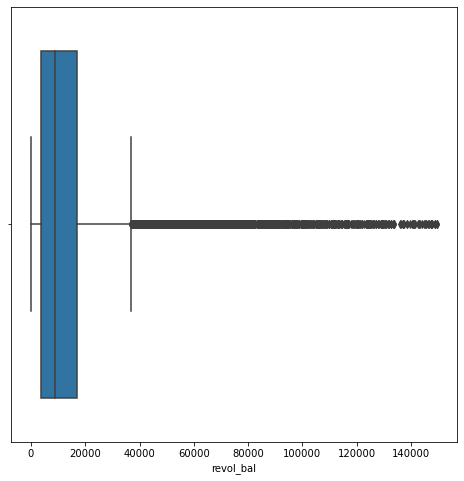

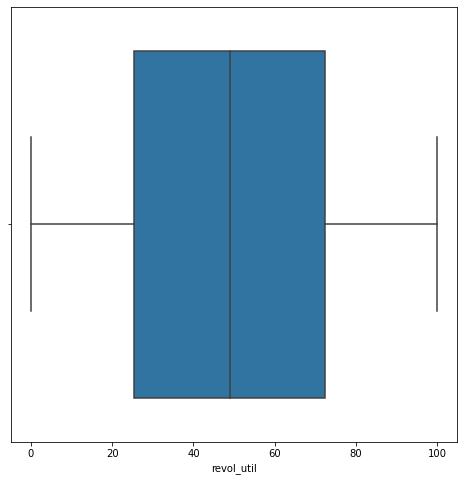

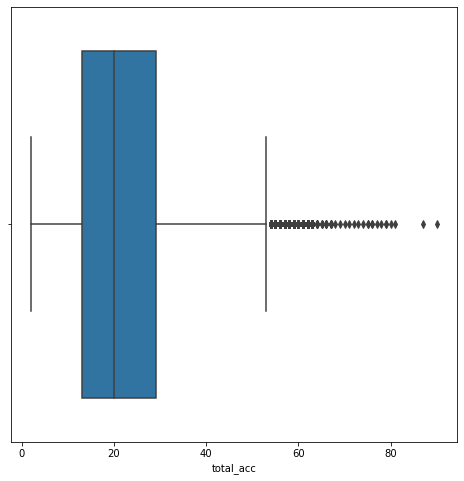

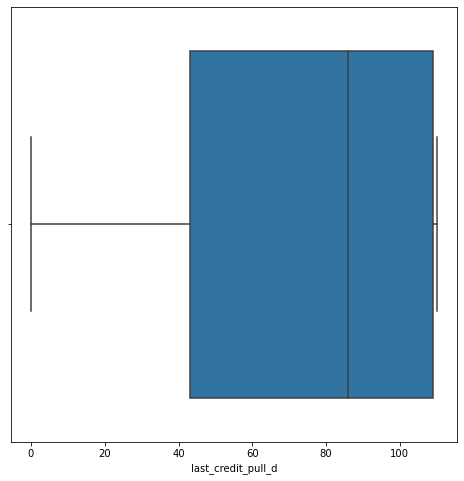

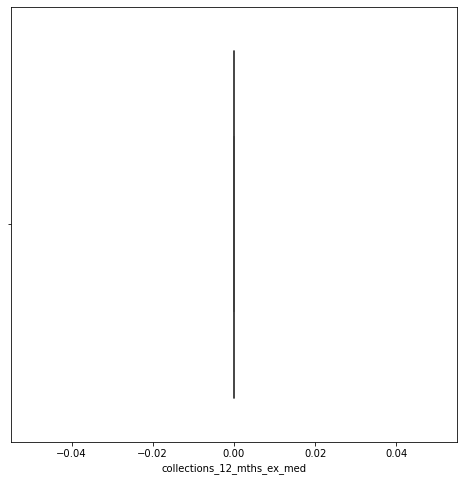

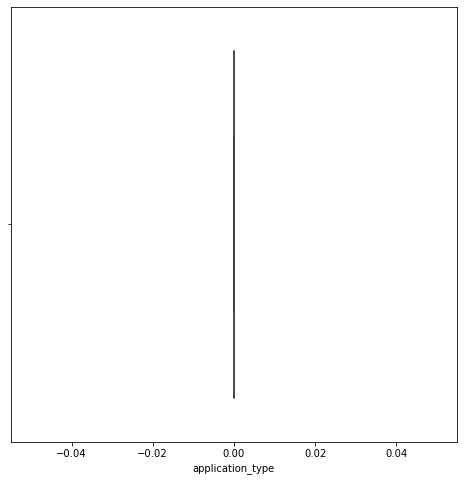

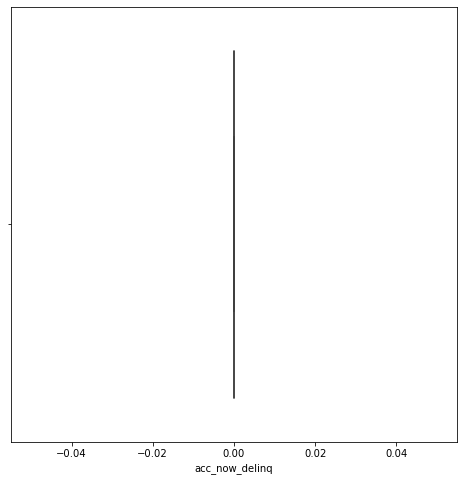

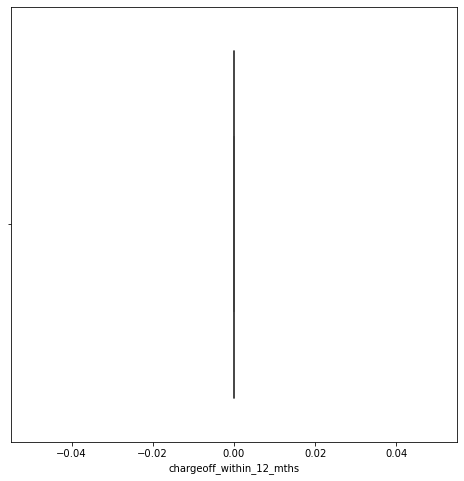

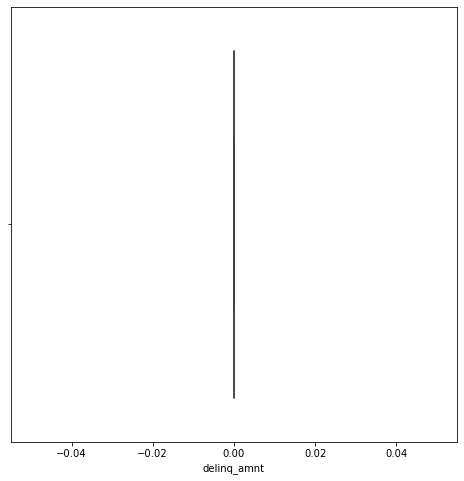

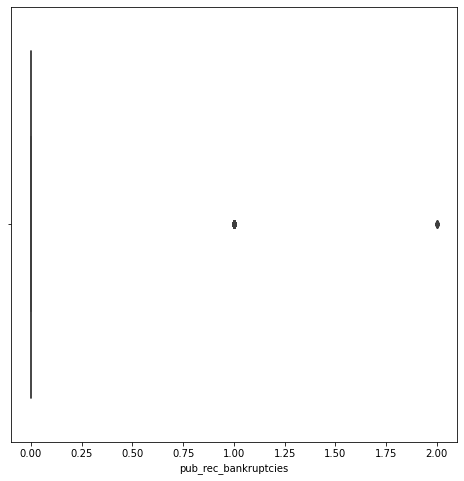

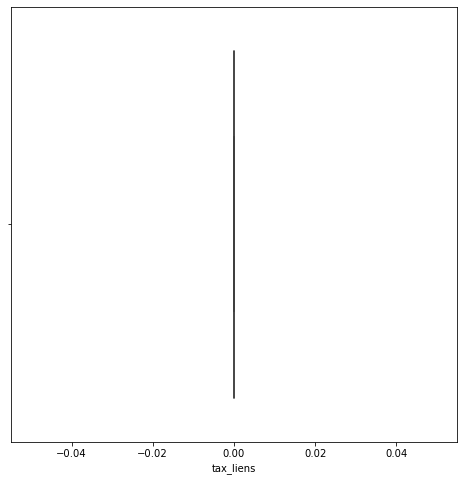

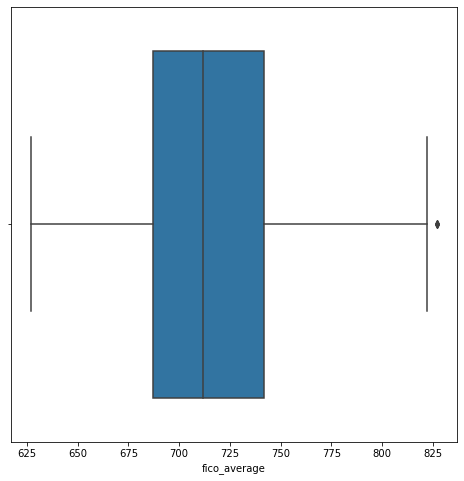

In [501]:
# get list for only dtypes 'int64 and 'float64'
list_columns = list(df.columns)

plt.rcParams['figure.figsize'] = (8, 8)

# Check for outliers
for column in list_columns:
    plt.figure()
    sns.boxplot(x=df[f'{column}'])

## Dealing with Missing Data

In [502]:
for column in list_columns:
    mean = df[f'{column}'].mean()
    std = df[f'{column}'].std()
    
    if(mean == 0 and std == 0):
        # drop columns with zero for mean and standard devitation
        df = df.drop(columns=[f'{column}'])
        print(f"{column} - mean: {mean} std: {std}")

collections_12_mths_ex_med - mean: 0.0 std: 0.0
application_type - mean: 0.0 std: 0.0
acc_now_delinq - mean: 0.0 std: 0.0
chargeoff_within_12_mths - mean: 0.0 std: 0.0
delinq_amnt - mean: 0.0 std: 0.0
tax_liens - mean: 0.0 std: 0.0


In [503]:
## Check if a distribution is close to the normal distribution

In [504]:
df = df.dropna()

In [505]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38492 entries, 0 to 39749
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             38492 non-null  float64
 1   term                  38492 non-null  int64  
 2   installment           38492 non-null  float64
 3   grade                 38492 non-null  int64  
 4   emp_length            38492 non-null  int64  
 5   home_ownership        38492 non-null  int64  
 6   annual_inc            38492 non-null  float64
 7   verification_status   38492 non-null  int64  
 8   loan_status           38492 non-null  int64  
 9   purpose               38492 non-null  int64  
 10  title                 38492 non-null  int64  
 11  addr_state            38492 non-null  int64  
 12  dti                   38492 non-null  float64
 13  delinq_2yrs           38492 non-null  float64
 14  earliest_cr_line      38492 non-null  int64  
 15  inq_last_6mths     

In [506]:
list_columns = list(df.columns)

## Check for outliers
#for column in list_columns:
#    mean = df[f'{column}'].mean()
#    std = df[f'{column}'].std()

#    print(f"{column} - mean: {mean} std: {std}")
#    stat, p = normaltest(df[f'{column}'])  # https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
#    print('Statistics=%.3f, p=%.3f' % (stat, p))
#
#    print(f'feature: {column} - mean: {mean} - std: {std}')
#    
#    # interpret
#    alpha = 0.05
#
#    for column_nan in list_columns_nan:
#        if(column_nan == column):
#            if(p > alpha):
#                print(f'feature: {column} - Sample looks Gaussian (fail to reject H0)')
#                df[f'{column}'] = df.fillna(df[f'{column}'].mean()) # inpute mean value 
#            else:
#                print(f'feature: {column} does not look Gaussian (reject H0)')
#                df[f'{column}'] = df.fillna(df[f'{column}'].median()) # impute median value


In [507]:
print(f'Number of rows.....................: {df.shape[0]}')
print(f'Number of columns..................: {df.shape[1]}')

Number of rows.....................: 38492
Number of columns..................: 24


In [508]:
# count NaN found in the dataset
df.isna().sum()

loan_amnt               0
term                    0
installment             0
grade                   0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
loan_status             0
purpose                 0
title                   0
addr_state              0
dti                     0
delinq_2yrs             0
earliest_cr_line        0
inq_last_6mths          0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
last_credit_pull_d      0
pub_rec_bankruptcies    0
fico_average            0
dtype: int64

# Visualization - Columns

array([[<AxesSubplot:title={'center':'addr_state'}>,
        <AxesSubplot:title={'center':'annual_inc'}>,
        <AxesSubplot:title={'center':'delinq_2yrs'}>,
        <AxesSubplot:title={'center':'dti'}>,
        <AxesSubplot:title={'center':'earliest_cr_line'}>],
       [<AxesSubplot:title={'center':'emp_length'}>,
        <AxesSubplot:title={'center':'fico_average'}>,
        <AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'home_ownership'}>,
        <AxesSubplot:title={'center':'inq_last_6mths'}>],
       [<AxesSubplot:title={'center':'installment'}>,
        <AxesSubplot:title={'center':'last_credit_pull_d'}>,
        <AxesSubplot:title={'center':'loan_amnt'}>,
        <AxesSubplot:title={'center':'loan_status'}>,
        <AxesSubplot:title={'center':'open_acc'}>],
       [<AxesSubplot:title={'center':'pub_rec'}>,
        <AxesSubplot:title={'center':'pub_rec_bankruptcies'}>,
        <AxesSubplot:title={'center':'purpose'}>,
        <AxesSubplot:title=

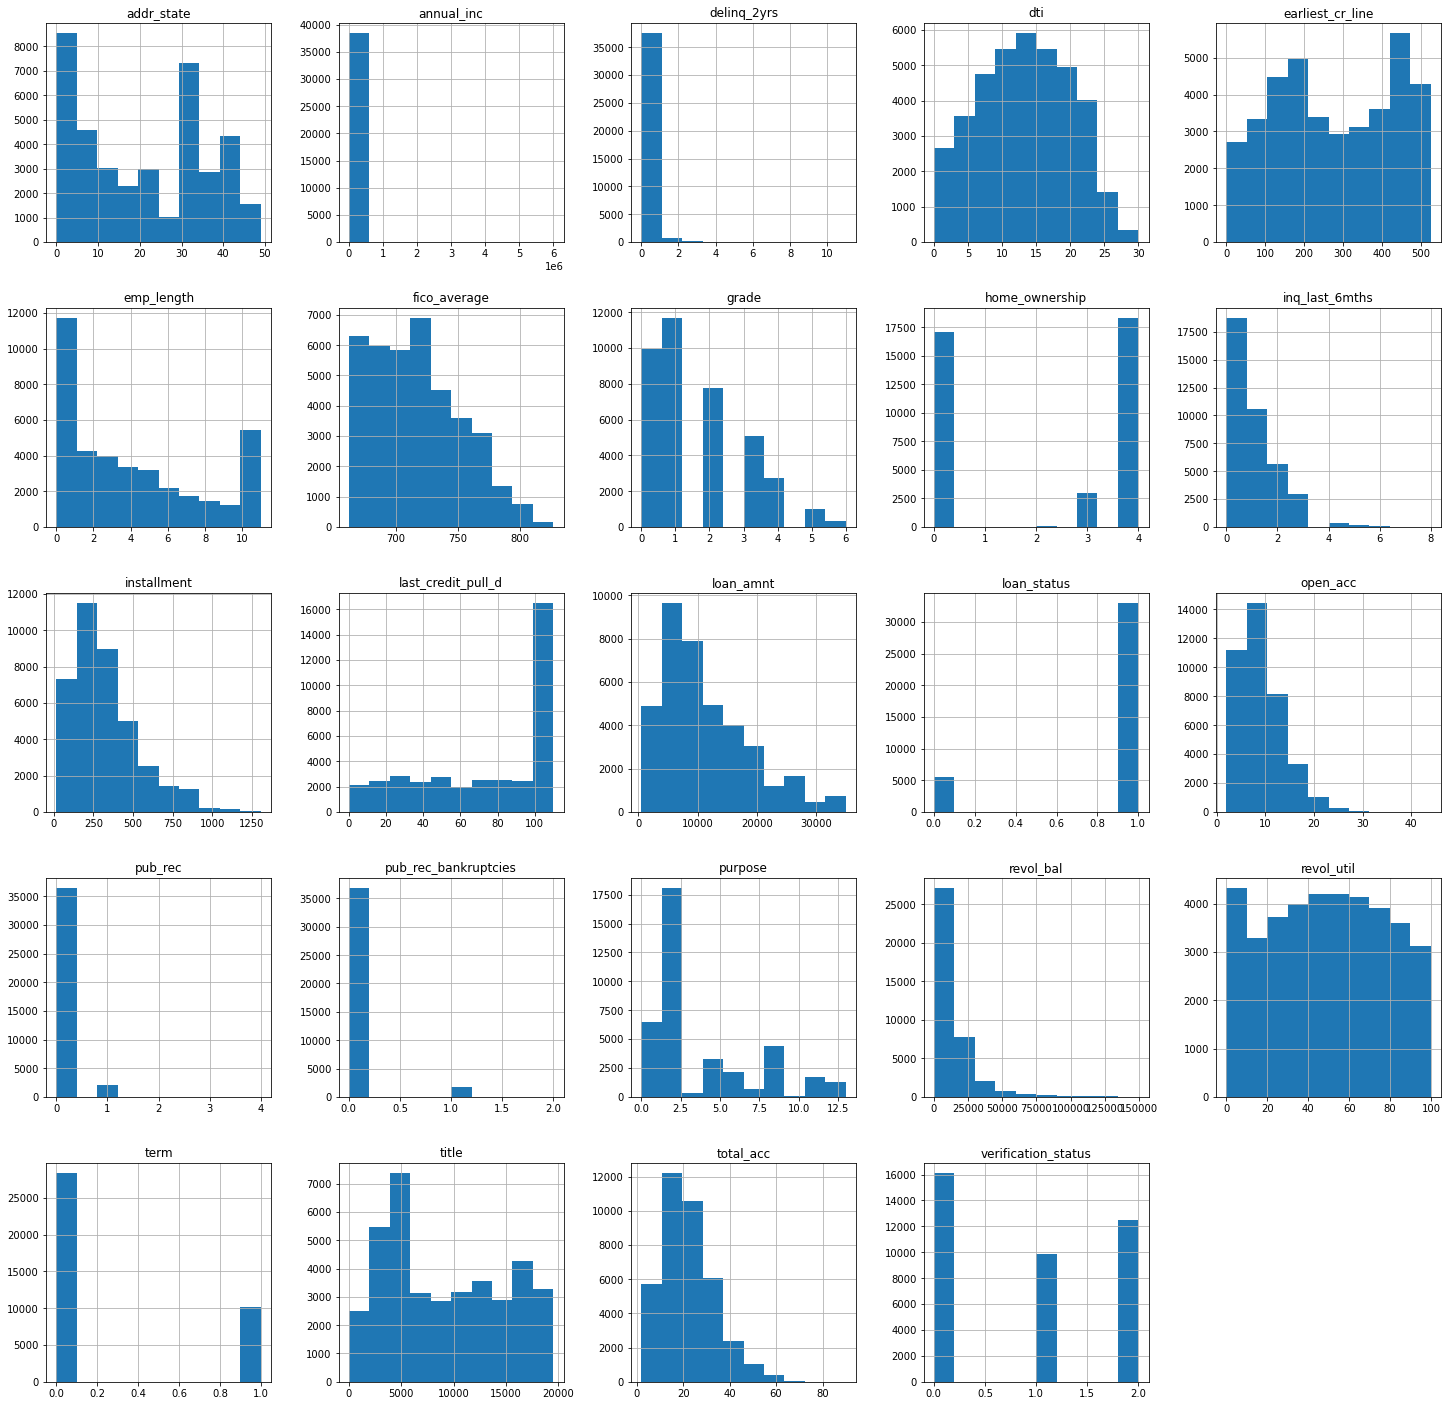

In [509]:
df.hist(figsize=(25, 25))

In [510]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38492 entries, 0 to 39749
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             38492 non-null  float64
 1   term                  38492 non-null  int64  
 2   installment           38492 non-null  float64
 3   grade                 38492 non-null  int64  
 4   emp_length            38492 non-null  int64  
 5   home_ownership        38492 non-null  int64  
 6   annual_inc            38492 non-null  float64
 7   verification_status   38492 non-null  int64  
 8   loan_status           38492 non-null  int64  
 9   purpose               38492 non-null  int64  
 10  title                 38492 non-null  int64  
 11  addr_state            38492 non-null  int64  
 12  dti                   38492 non-null  float64
 13  delinq_2yrs           38492 non-null  float64
 14  earliest_cr_line      38492 non-null  int64  
 15  inq_last_6mths     

In [511]:
# Exploring it and understanding what feature each column represents.

# data dictionary 
data_dictionary = pd.read_csv('../data/LCDataDictionary.csv') # Loading in the data dictionary
#print(data_dictionary.shape[0])
#print(data_dictionary.columns.tolist())

In [512]:
data_dictionary = data_dictionary.dropna()

list_columns_all = list(df.columns)

ii = 1
for index, row in data_dictionary.iterrows():
       col1 = row['LoanStatNew']
       col2 = row['Description']

       for icol in list_columns_all:
            if(col1 == icol):
               print(f'# {ii} - {col1}: .......{col2}')
               ii = ii+1

# 1 - addr_state: .......The state provided by the borrower in the loan application
# 2 - annual_inc: .......The self-reported annual income provided by the borrower during registration.
# 3 - delinq_2yrs: .......The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
# 4 - dti: .......A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
# 5 - earliest_cr_line: .......The month the borrower's earliest reported credit line was opened
# 6 - emp_length: .......Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
# 7 - grade: .......LC assigned loan grade
# 8 - home_ownership: .......The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.
# 9 - inq_last_6mt

In [513]:
# Generates profile reports from a pandas DataFrame
# pandas_profiling extends the pandas DataFrame with 
# df.profile_report() for quick data analysis
# This request a lot of memory RAM.
# Pandas Profiling on github: https://github.com/pandas-profiling/pandas-profiling
profile = ProfileReport(df, title="Pandas Profiling Report")

In [514]:
# report format html
# A nice way to explore the data. Take a look :)
#!mkdir reports

#profile.to_file("reports/index.html")

# open reports/lending_club_loans.html in a browser

In [515]:
print(f'Number of rows.....................: {df.shape[0]}')
print(f'Number of columns..................: {df.shape[1]}')

Number of rows.....................: 38492
Number of columns..................: 24


In [516]:
print("saving the file feather-format...")

# this is important to do before save in feather format.
df = df.reset_index(drop=True) # reset index pandas before save feather format
df.to_feather('../data/dataset_cleaning.ftr') # save to feather format

release_memory(df)

saving the file feather-format...
memory RAM released.


In [517]:
# time of execution in minutes
time_exec_min = round( (time.time() - start_time)/60, 4)

print(f'time of execution (preprocessing/cleaning): {time_exec_min} minutes')
print("the preprocessing is done.")
print("The next step is to do the feature engineering.")
# datetime object containing current date and time
now = datetime.now()

# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print(">>> date: ", dt_string)

print("All Done. :)")

time of execution (preprocessing/cleaning): 0.3746 minutes
the preprocessing is done.
The next step is to do the feature engineering.
>>> date:  15/08/2021 19:18:26
All Done. :)
